## Machine Learning - Clustering

Drafting in fantasy can best be done my catagorizing players into tiers vs. a bottom down ranking system. Here I will be creating my own Fantasy Football tiers for the 2022 season. Players in the same tier can be seen as equal when drafting.

Data can be pulled from https://www.fantasypros.com/nfl/rankings/half-point-ppr-cheatsheets.php and changing the "View" filter to "Ranks." Download the data and read the file in. As fantasy rankings adjust during the pre-season, we can re-run the program to obtain new results of tiers.

In [1]:
#Read in data, only want players that will be drafted
import pandas as pd
pd.set_option('display.max_rows', None)
df = pd.read_csv('FantasyPros_2022_Draft_ALL_Rankings (2).csv')
num_teams = 12 #12 team league, can change to 8
roster_spots = 15 #Number of roster spots, can adjust according to league rules
draft_pool = num_teams * roster_spots #Total players that will be drafted
df = df[:draft_pool]
del df['TIERS'] #Delete the tiers column, I will be making new tiers
print(df)
df.shape

      RK               PLAYER NAME TEAM   POS  BEST  WORST   AVG.  STD.DEV  \
0      1           Jonathan Taylor  IND   RB1     1      3    1.1      0.4   
1      2       Christian McCaffrey  CAR   RB2     1     12    3.1      2.0   
2      3             Austin Ekeler  LAC   RB3     2     12    4.3      1.8   
3      4             Derrick Henry  TEN   RB4     1     18    5.0      2.8   
4      5               Dalvin Cook  MIN   RB5     2     16    6.0      2.6   
5      6               Cooper Kupp  LAR   WR1     2     15    6.5      3.0   
6      7              Najee Harris  PIT   RB6     2     20    7.9      4.0   
7      8          Justin Jefferson  MIN   WR2     2     13    8.2      2.7   
8      9                 Joe Mixon  CIN   RB7     3     18    9.2      3.0   
9     10             Ja'Marr Chase  CIN   WR3     4     21    9.7      3.6   
10    11             Davante Adams   LV   WR4     7     23   13.9      3.2   
11    12              Stefon Diggs  BUF   WR5     8     21   14.

(180, 9)

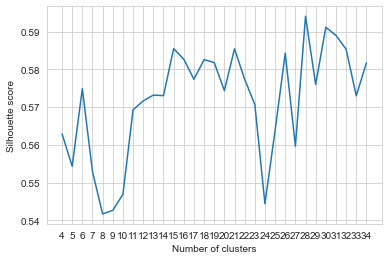

In [2]:
#Find the most optimal number of K clusters using silhouette score

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; sns.set_style('whitegrid');

avgs = []

#Iterate from k=4 -> k=34 and try to find the silhouette score for each value of K.
#Choose the K that results in the highest score.

start = 4 
stop = 35

for n_clusters in range(start, stop):
    #Using AVG. column to create initial matrix
    X = df[['AVG.']].values

    model = KMeans(n_clusters=n_clusters) #instantiate the model with hyperparameters
    
    model.fit(X) #fit the model
    
    labels = model.predict(X) #predict labels (assign clusters) to our data
    
    silhouette_avg = silhouette_score(X, labels) #calculate the silhouette avg for our labels
    
    avgs.append(silhouette_avg) #append it to a list for plotting later

#Plot results
plt.plot(np.arange(start, stop, 1), avgs);
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette score');
plt.xticks(np.arange(start, stop, 1));

In [3]:
#Since k=33 gives the highest silhoutette score, I'll use k=33
#Adjust accordingly based on the result of silhoutette score
k = 33
model = KMeans(n_clusters=k)
model.fit(X)
labels = model.predict(X)

def assign_tiers(labels):
    #Map the random labels to fantasy football tiers
    unique_labels = []
    tiers = []
    
    for i in labels:
        
        if i not in unique_labels:
            unique_labels.append(i)
        tiers.append(len(set(unique_labels)))
    return tiers

#Assign new tiers to df
tiers = assign_tiers(labels)
df['TIER'] = tiers
df.head(10)

,RK,PLAYER NAME,TEAM,POS,BEST,WORST,AVG.,STD.DEV,ECR VS. ADP,TIER
0,1,Jonathan Taylor,IND,RB1,1,3,1.1,0.4,0,1
1,2,Christian McCaffrey,CAR,RB2,1,12,3.1,2.0,+3,1
2,3,Austin Ekeler,LAC,RB3,2,12,4.3,1.8,-1,1
3,4,Derrick Henry,TEN,RB4,1,18,5.0,2.8,-1,1
4,5,Dalvin Cook,MIN,RB5,2,16,6.0,2.6,+1,1
5,6,Cooper Kupp,LAR,WR1,2,15,6.5,3.0,-2,2
6,7,Najee Harris,PIT,RB6,2,20,7.9,4.0,0,2
7,8,Justin Jefferson,MIN,WR2,2,13,8.2,2.7,0,2
8,9,Joe Mixon,CIN,RB7,3,18,9.2,3.0,0,2
9,10,Ja'Marr Chase,CIN,WR3,4,21,9.7,3.6,0,2


In [4]:
#Visualize the new tiers
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('whitegrid')

def make_clustering_viz(df, pos=None, figsize=(20,20)):
    
    #If creating tiers for specific position
    if pos:
        df = df.loc[df['POS'].str.contains(pos)]  
        #https://htmlcolorcodes.com/
    colors = ['purple', 'magenta', 'red', 'blue', 'orange', 'green',
              'salmon', 'yellow', 'black', 'grey', '#3498db', '#16a085', '#f4d03f', '#f1948a',
              '#48c9b0', '#3498db', '#e74c3c', '#d7bde2', '#d0d3d4', 'purple', 'magenta', 'red', 'blue',
            'orange', 'green', 'salmon', 'yellow', 'black', 'grey', '#3498db', '#16a085', '#f4d03f', '#f1948a',
              '#48c9b0', '#3498db', '#e74c3c', '#d7bde2', '#d0d3d4']
    colors = dict(zip(range(1,k+1), colors[:k]))
        
    plt.figure(figsize=figsize)
        #Plot Avg vs. Rank
    plt.scatter(x=df['AVG.'],
                   y=df['RK'],
                   c='#212f3d',
                   alpha=0.9,
                   s=7)
    yticks = [] #store player-names on the y-axis
        
    for _, row in df.iterrows():
            
            #Plot a horizontal line along each point with a range from Max to Min draft ranking
        xmin = row['BEST']
        xmax = row['WORST']
        ymin, ymax = row['RK'], row['RK']
        player = row['PLAYER NAME']
        tier = row['TIER']
        
        plt.plot((xmin,xmax),(ymin,ymax), c=colors.get(tier,'black'), alpha=0.8)
        
        yticks.append(player) #append yticks list with player's name
            
        #Create a legend
    patches = []
    for tier, color in colors.items():
        patch = mpatches.Patch(color=color, label=f'Tier {tier}')
        patches.append(patch)
        
    plt.legend(handles=patches, borderpad=1, fontsize=12)
    plt.xlabel('Average Expert Rank', fontsize=12)
    plt.ylabel('Expert Consensus Rank', fontsize=12)
    plt.yticks(df['RK'], yticks, fontsize=10)
    plt.title('Tiers for 2022 Draft. ECR vs Average Expert Rank', fontsize=12)
        
    plt.gca().invert_yaxis()
    plt.show()

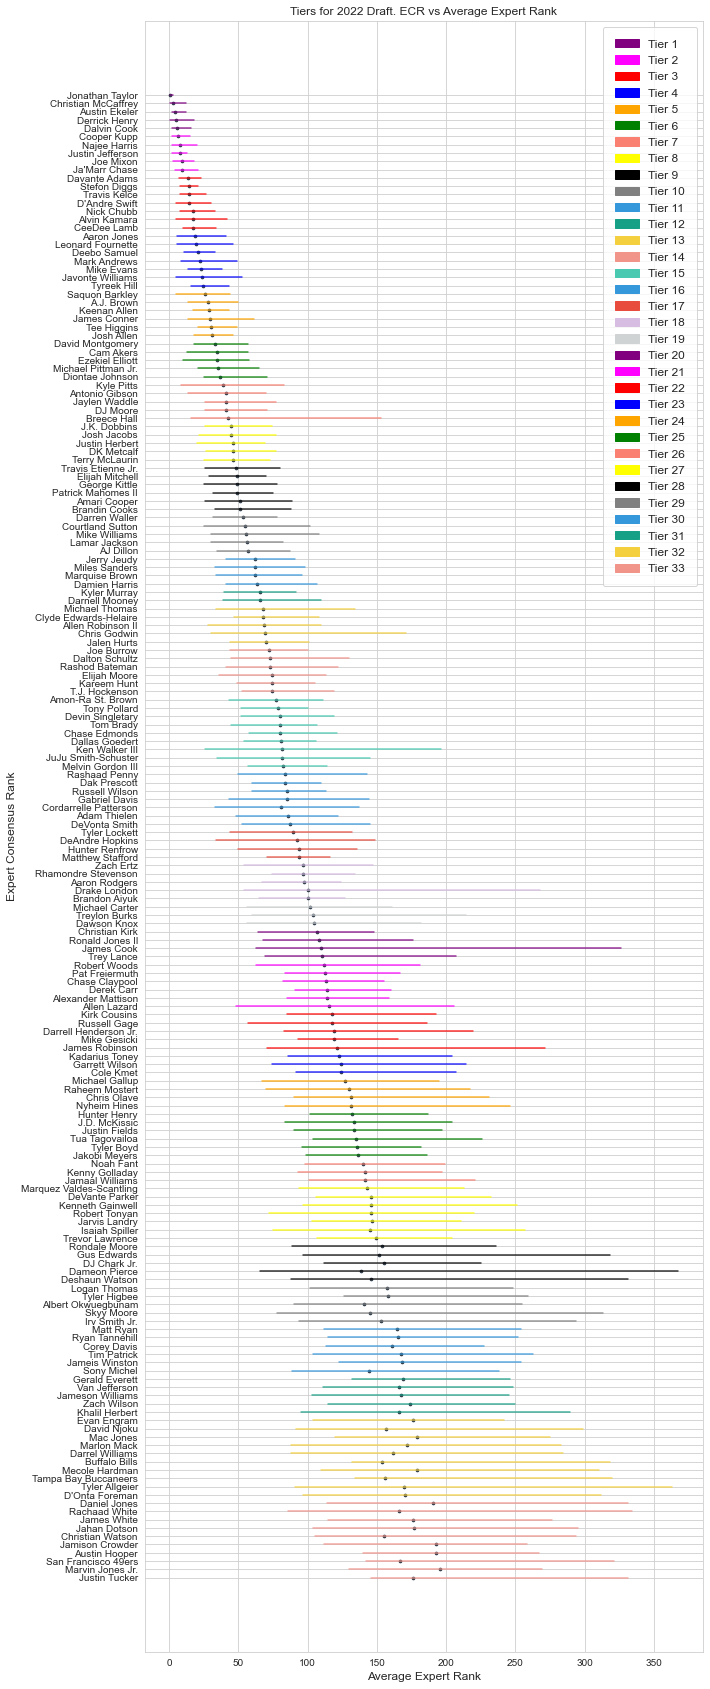

In [5]:
#View tier ranking for all players
make_clustering_viz(df, figsize=(10, 30))

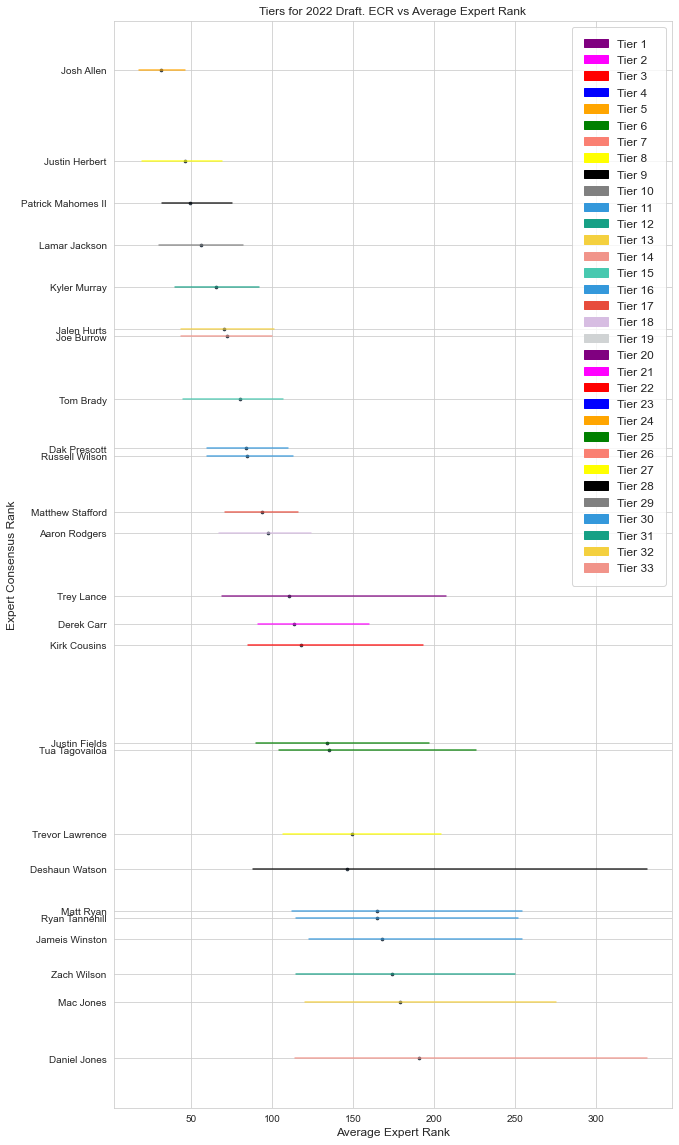

In [6]:
#Quarterbacks
make_clustering_viz(df, 'QB', figsize=(10, 20))

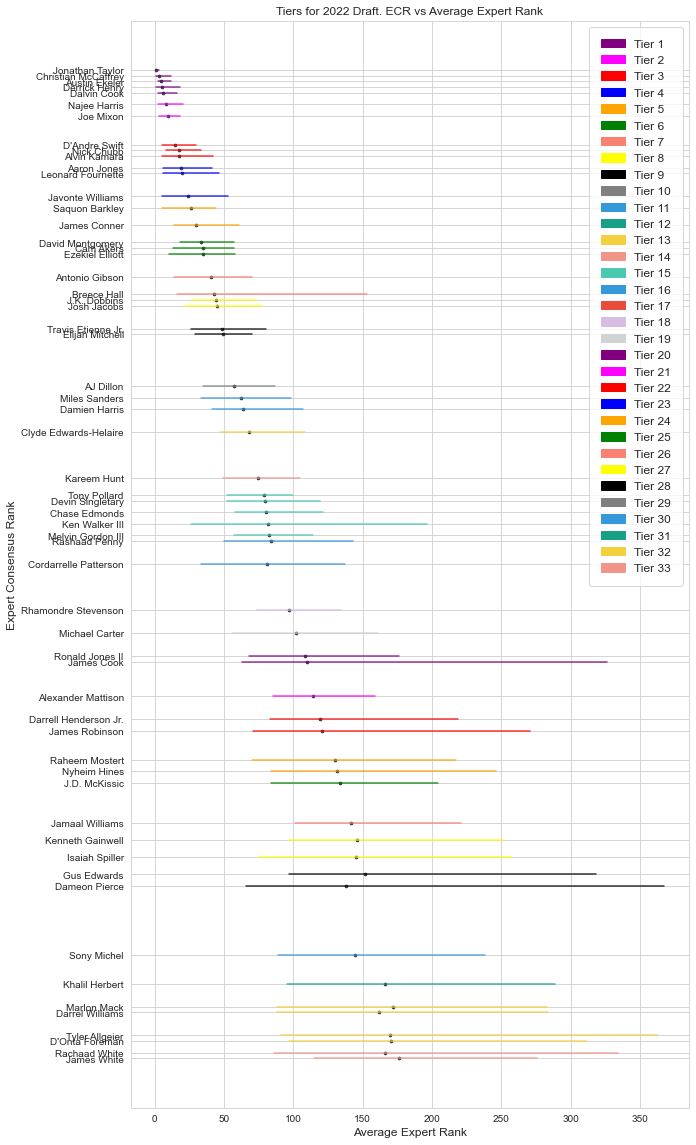

In [7]:
#Running backs
make_clustering_viz(df, 'RB', figsize=(10, 20))

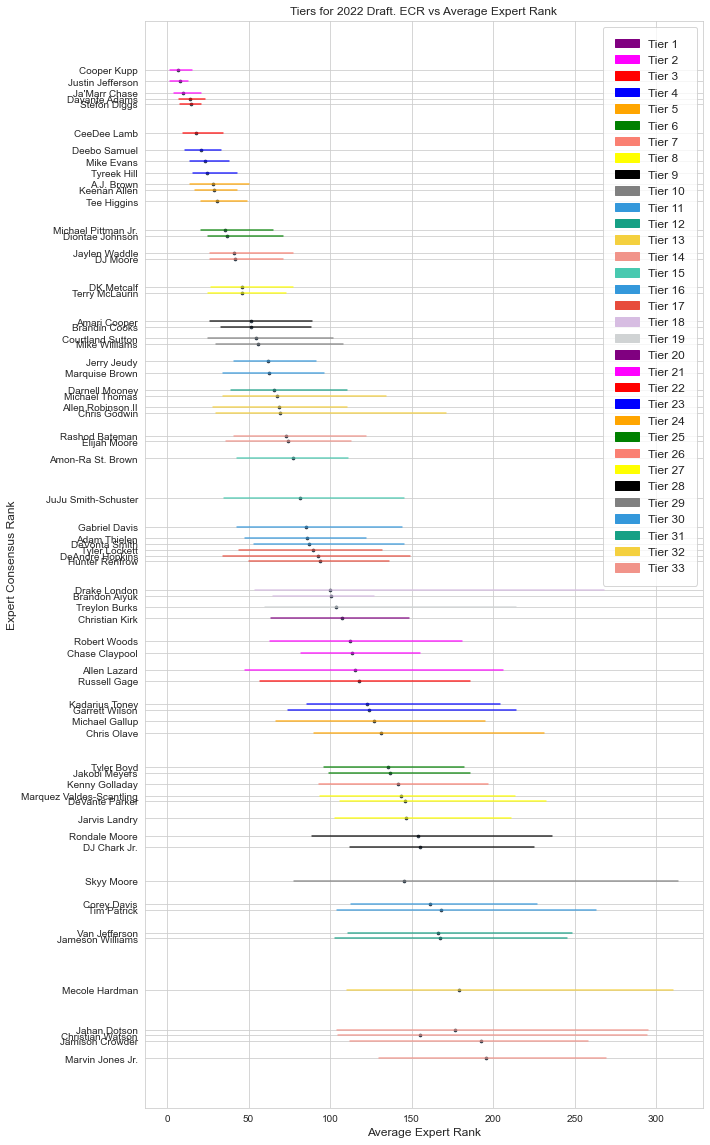

In [8]:
#Wide Receivers
make_clustering_viz(df, 'WR', figsize=(10, 20))

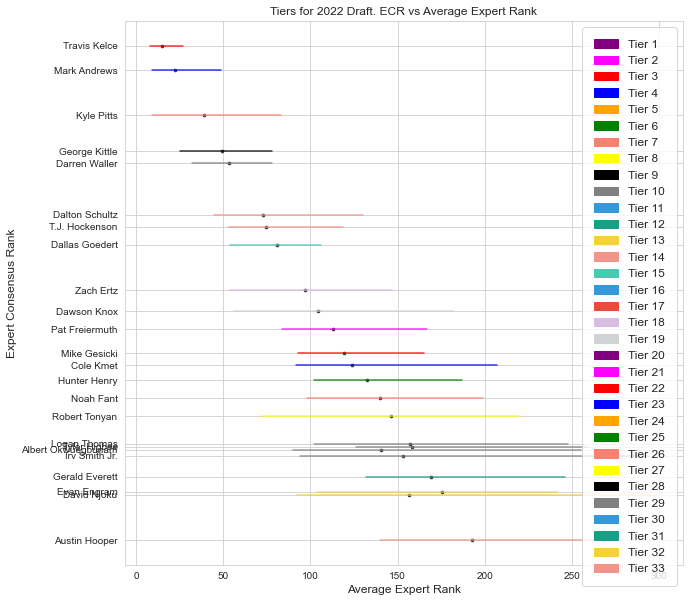

In [9]:
#Tight Ends
make_clustering_viz(df, 'TE', figsize=(10, 10))